# Analysis of Judge Sex Ratios

## Set up a dashboard to monitor ongoing dask operations.

In [35]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
from pathlib import Path

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

client = Client()
client

/home/advin4603/PrecogRecruitmentTask/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37247 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37247/status,
Dashboard: http://127.0.0.1:37247/status,Workers: 4
Total threads: 8,Total memory: 15.52 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40937,Workers: 4
Dashboard: http://127.0.0.1:37247/status,Total threads: 8
Started: Just now,Total memory: 15.52 GiB
Comm: tcp://127.0.0.1:40563,Total threads: 2
Dashboard: http://127.0.0.1:37071/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:35815,


## Load Judge Data in a Dask Dataframe

Dask uses lazy loading so data isn't loaded onto the RAM.

In [36]:
date_parser = lambda x: pd.to_datetime(str(x), errors='coerce', format="%d-%m-%Y")
case_date_parser = lambda x: pd.to_datetime(str(x), errors='coerce', format="%Y-%m-%d")
judges = dd.read_csv(Path("./csv/judges_clean.csv"), dtype={
    "ddl_judge_id": "int32",
    "state_code": "category",
    "dist_code": "category",
    "court_no": "category",
    "judge_position": "category",
    "female_judge": "category",
    "start_date": "string[pyarrow]",
    "end_date": "string[pyarrow]"
}, parse_dates=["start_date", "end_date"], date_parser=date_parser)
judges

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date
npartitions=1,,,,,,,,
,int32,category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],datetime64[ns],datetime64[ns]
,...,...,...,...,...,...,...,...


## Calculate The Sex Ratio of judges for all of India

In [37]:
sex_ratio = judges["female_judge"].value_counts(normalize=True).compute() * 100
sex_ratio

0 nonfemale                    68.58
1 female                       27.62
-9998 unclear                   3.79
Name: female_judge, dtype: float64

## Calculate The State-Wise Sex Ratio of judges for all of India

Meghalaya has the highest female representation.

In [38]:
state_wise_sex_ratio = judges[["state_code", "female_judge"]].compute().groupby(["state_code"])[
                           "female_judge"].value_counts(normalize=True) * 100
state_wise_sex_ratio

state_code  female_judge 
1           0 nonfemale                    70.21
            1 female                       27.77
            -9998 unclear                   2.02
10          0 nonfemale                    63.13
            1 female                       35.23
            -9998 unclear                   1.64
11          0 nonfemale                    66.72
            1 female                       33.09
            -9998 unclear                   0.20
12          0 nonfemale                    82.53
            1 female                       16.26
            -9998 unclear                   1.21
13          0 nonfemale                    78.74
            1 female                       20.98
            -9998 unclear                   0.28
2           0 nonfemale                    64.60
            1 female                       34.95
            -9998 unclear                   0.46
3           0 nonfemale                    64.21
            1 female                       

## Calculate The District-Wise Sex Ratio of judges for all of India

Maharashtra-School Tribunals has the highest female representation

In [39]:
district_wise_sex_ratio = \
    judges[["state_code", "dist_code", "female_judge"]].compute().groupby(["state_code", "dist_code"])[
        "female_judge"].value_counts(normalize=True) * 100
district_wise_sex_ratio

state_code  dist_code  female_judge 
1           1          0 nonfemale                    89.38
                       1 female                       10.62
                       -9998 unclear                   0.00
            10         0 nonfemale                    50.00
                       1 female                       42.44
                       -9998 unclear                   7.56
            11         0 nonfemale                    86.79
                       1 female                       12.58
                       -9998 unclear                   0.63
            12         0 nonfemale                    89.58
                       -9998 unclear                  10.42
                       1 female                        0.00
            13         0 nonfemale                    67.70
                       1 female                       31.10
                       -9998 unclear                   1.20
            14         0 nonfemale                    80.08
   

## Calculate the Court-Wise Sex Ratio of judges for all of India

In [40]:
court_wise_sex_ratio = judges[["state_code", "dist_code", "court_no", "female_judge"]].compute().groupby(
    ["state_code", "dist_code", "court_no"])["female_judge"].value_counts(normalize=True) * 100
court_wise_sex_ratio

state_code  dist_code  court_no  female_judge 
1           1          1         0 nonfemale                    91.84
                                 1 female                        8.16
                                 -9998 unclear                   0.00
                       10        0 nonfemale                   100.00
                                 -9998 unclear                   0.00
                                 1 female                        0.00
                       16        0 nonfemale                    81.82
                                 1 female                       18.18
                                 -9998 unclear                   0.00
                       17        0 nonfemale                   100.00
                                 -9998 unclear                   0.00
                                 1 female                        0.00
                       2         0 nonfemale                    95.83
                                 1 female  

## Plot the State-wise sex ratios on the India Map.

There might be slight inaccuracies as the changes in the Indian Map across the years isn't accounted for.

<AxesSubplot: title={'center': 'Percentage Female Judges in District Courts'}>

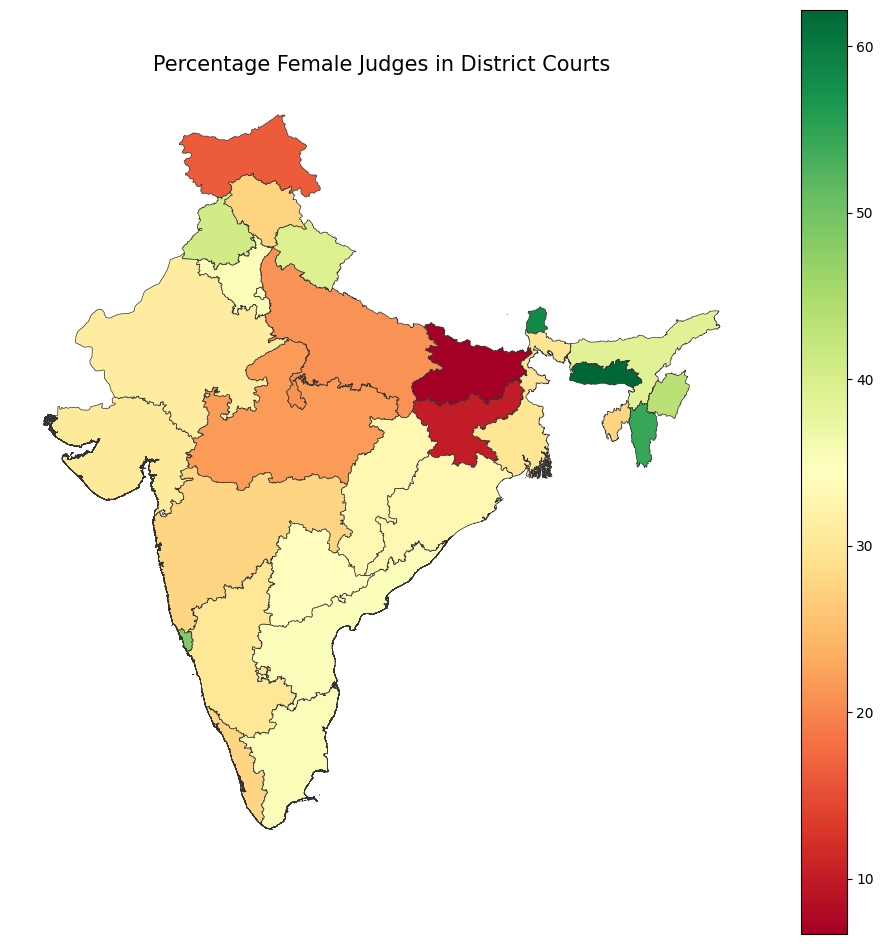

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt


state_female_percentages = [(int(state_code), state_percentage) for (state_code, sex), state_percentage in
                            state_wise_sex_ratio.items() if sex == "1 female"]

shape_gdf = gpd.read_file("./stateShapefile/IND_adm1.shp")
state_female_percentages_df = pd.DataFrame(state_female_percentages, columns=["state_code", "percentage"])
state_keys = pd.read_csv("./csv/keys/keys/cases_state_key.csv")
state_female_percentages_df["NAME_1"] = state_female_percentages_df["state_code"].apply(
    lambda x: list(state_keys[state_keys["state_code"] == x]["state_name"].head(1).items())[0][1])
name_transform = {
    "Orissa": "Odisha",
    "Delhi": "NCT of Delhi"
}
state_female_percentages_df["NAME_1"] = state_female_percentages_df["NAME_1"].apply(
    lambda x: name_transform[x] if x in name_transform else x)
state_female_percentages_merged = shape_gdf.set_index('NAME_1').join(state_female_percentages_df.set_index("NAME_1"))

_, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Percentage Female Judges in District Courts',
             fontdict={'fontsize': '15', 'fontweight': '3'})
fig = state_female_percentages_merged.plot(column='percentage', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2',
                                           legend=True)
fig

## Plot the District-wise sex ratios on the India Map.

### Does not work properly due to the differences in naming of districts.
- A lookup table was used to account for this but it failed to account for all of the inaccuracies.
- A fuzzy name matching algorithm may be able to mitigate this issue.

<AxesSubplot: title={'center': 'Percentage Female Judges in District Courts'}>

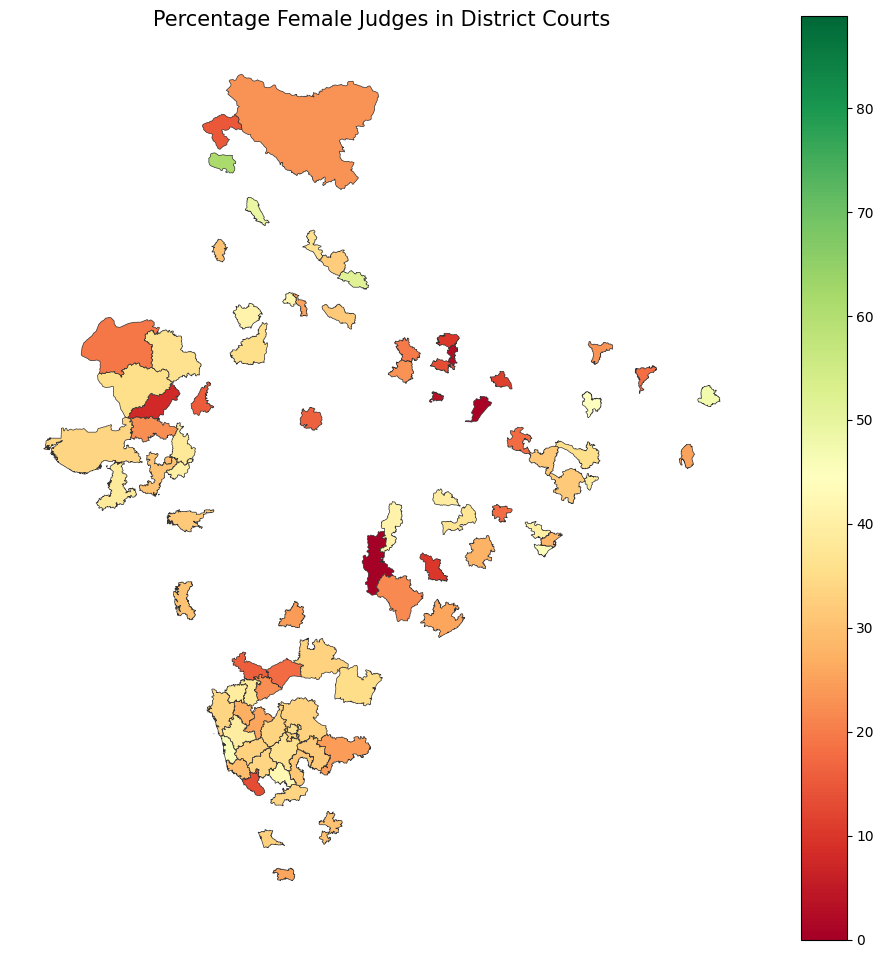

In [42]:
district_shape_gdf = gpd.read_file("./districtShapeFile/polbnda_ind.shp")
district_shape_gdf["district_name"] = district_shape_gdf["laa"]
district_female_percentages = pd.DataFrame(
    ((int(state_code), int(district_code), state_percentage) for (state_code, district_code, sex), state_percentage in
     district_wise_sex_ratio.items() if sex == "1 female"), columns=["state_code", "dist_code", "percentage"])
district_keys = pd.read_csv("./csv/keys/keys/cases_district_key.csv")
district_female_percentages = pd.merge(district_female_percentages,
                                       district_keys[["state_code", "dist_code", "state_name", "district_name"]],
                                       on=["state_code", "dist_code"])

district_name_transform = {
    "Gondia": "Gondiya",
    "Gadchiroli": "GARHCHIROLI",
    "Raigad": "Raigarh",
    "Ahmednagar": "Ahmadnagar",
    "Beed": "Bid",
    "Buldhana": "Buldana",
    "Viluppuram": "Villupuram",
    "Virudhunagar": "Virudunagar",
    "Madurai": "Madhurai",
    "The Nilgiris": "Nilgiri",
    "Tiruvarur": "Tiruvallur",
    "Puducherry": "Pondicherry",
    "Sivagangai": "Sivaganga",
    "Kancheepuram": "Kanchipuram",
    "Theni": "Teni",
    "Nagapattinam": "Nagappattinam",
    'UTTARA KANNADA': 'UTTAR KANNAD',
    'SHIVAMOGGA': 'SHIMOGA',
    'CHIKKAMAGALURU': 'CHIKMAGALUR',
    'TUMAKURU': 'TUMKUR',
    'BENGALURU RURAL': 'BANGALORE RURAL',
    'DAKSHINA KANNADA': 'DAKSHIN KANNAD',
    'Tiruchirappalli': 'TIRUCHCHIRAPPALLI',
    'Jagatsinghpur': 'JAGATSINGHAPUR',
    'Jajpur': 'JAJAPUR',
    'Kendrapada': 'KENDRAPARHA',
    'Rayagada': 'RAYGAD',
    'Kandhamal': 'PHULABANI (KANDHAMAL)',
    'Bargarh': 'BARAGARH',
    'Nabarangpur': 'NABARANGAPUR',
    'Leh': 'LEH (LADAKH)',
    'Baramulla': 'BARAMULA', 'Reasi': 'RIASI',
    'Ambedkar Nagar': 'AMBEDKARNAGAR',
    'Budaun': 'BADAUN',
    'Gautam Buddha Nagar': 'GAUTAMBUDH NAGAR',
    'Bhadohi SR Nagar': 'SANT RAVI DAS NAGAR(BHADOHI)',
    'Barabanki': 'BARA BANKI',
    'Raebareli': 'RAE BARELI',
    'Siddharthnagar': 'SIDDHARTH NAGAR',
    'Santkabir Nagar': 'SANT KABIR NAGAR',
    'Prakasham': 'PRAKASAM',
    'Ananthapur': 'ANANTAPUR',
    'Visakapatnam': 'VISHAKHAPATNAM',
    'Pathanamthitta': 'PATTANAMTITTA',
    'Thrissur': 'TRISHSHUR',
    'Dhubri': 'DHUBURI',
    'Deoghar': 'DEOGARH',
    'Hazaribagh': 'HAZARIBAG',
    'Rohtas Sasaram': 'ROHTAS',
    'Saran at Chapra': 'CHHAPRA',
    'Rajsamand': 'RAJ SAMAND',
    'Jhunjhunu': 'JHUNJHUNUN',
    'Jalore': 'JALOR',
    'Balotra Barmer': 'BARMER',
    'Jodhpur Metro': 'JODHPUR',
    'Chittorgarh': 'CHITTOOR',
    'Jaiselmer': 'JAISALMER',
    'Jaipur District': 'JAIPUR',
    'Nainital': 'NAINI TAL',
    'Pauri Garhwal': 'GARHWAL',
    'Dehradun': 'DEHRA DUN',
    'Malda': 'MALDAH',
    'Purulia': 'PURULIYA',
    'Howrah': 'HAORA',
    'Darjeeling': 'DARJILING',
    'Purba Bardhaman': 'BARDDHAMAN',
    'Paschim Medinpur': 'PASHCHIM MEDINIPUR',
    'Ahmedabad': 'AHMADABAD',
    'Banaskanth at Palanpur': 'BANAS KANTHA',
    'Kheda at Nadiad': 'KHEDA',
    'kachchh at Bhuj': 'KACHCHH',
    'Sabarkantha at Himmatnagar': 'SABAR KANTHA',
    'Rajnandgaon': 'RAJ NANDGAON',
    'Dantewada': 'DANTEWARA',
    'Janjgir': 'JANJGIR CHAMPA',
    'SouthTripura': 'SOUTH TRIPURA',
    'West Jaintia Hills': 'JAINTIA HILLS',
    'Sri Muktsar Sahib': 'MUKTSAR',
    'Hoshiarpurr': 'HOSHIARPUR',
    'Ashoknagr': 'ASHOKNAGAR',
    'New Delhi': 'DELHI',
    'Mahabubnagar': 'MAHBUBNAGAR'
}
district_female_percentages["district_name"] = district_female_percentages["district_name"].apply(
    lambda x: district_name_transform.get(x, x))

district_female_percentages_merged = district_shape_gdf.merge(district_female_percentages, how="right", left_on="laa",right_on="district_name")

_, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Percentage Female Judges in District Courts',
             fontdict={'fontsize': '15', 'fontweight': '3'})
fig = district_female_percentages_merged.plot(column='percentage', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2',
                                           legend=True)
fig